# **Avance 2. Series de tiempo univariadas:**
## **Universidad Nacional de Colombia.**
## **Docente:**

  - [Sergio Alejandro Calderón Villanueva](sacalderonv@unal.edu.co)

## **Autores:**

  - [Michel Mendivenson Barragán Zabala](mbarraganz@unal.edu.co)
  - [Sharon Juliana Zambrano Ortiz](shzambranoo@unal.edu.co)
  - [Nicolás Alejandro Quenguan Parra](naquenguanp@unal.edu.co)
  - [Aryin Jair Torres Quiñone](artorresq@unal.edu.co)

---
**Nota 1:** Los avances estaban siendo realizados en archivos de Rmarkdown `.Rmd`. Sin embargo, como la intención de este avance es incluir algunos modelos de aprendizaje profundo (Redes neuronales multicapa y redes recurrentes) con el fin de no utilizar recursos de computo de los equipos de cada uno de los autores se entregará el avance 2 como un archivo de jupyter notebook `.ipynb` que además de permitir el uso de computación en la nube para tareas pesadas usando Google Collab cuando los recursos de forma local sean reducidos también (Por ser `python`) permite construir chunks que usen código de `R` y `python` cuyos objetos tienen la posibilidad de interactuar entre sí (Veáse: [R and Python in one Jupyter notebook](https://stackoverflow.com/questions/39008069/r-and-python-in-one-jupyter-notebook))

**Nota 2:** Si se está editando este documento desde Google Collab, no es posible hacer `commit` directamente al repositorio. En cambio, hay que dar en la opción `File > Save a copy in GitHub`.

---

En este avance, se encuentra lo correpondiente a la implementación de árboles de decisión, filtro exponencial y redes neuronales para las dos series escogidas para el desarrollo del curso:

In [56]:
# Este módulo es usado para correr código de R y hacer que los objetos de R interactuén con python
%load_ext rpy2.ipython

# Manejo de datos en general
import pandas as pd
import numpy as np

# Para poder graficar
import matplotlib.pyplot as plot

# Construcción del árbol de decisión
from sklearn.tree import DecisionTreeRegressor

# Tuning del árbol
from skforecast.ForecasterAutoreg import ForecasterAutoreg

# Medidas de precisión
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Para el ajuste de hiperparámetros
from skforecast.model_selection import grid_search_forecaster

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# **Volumen de acopio nacional de leche (Frecuencia mensual)** 🐮

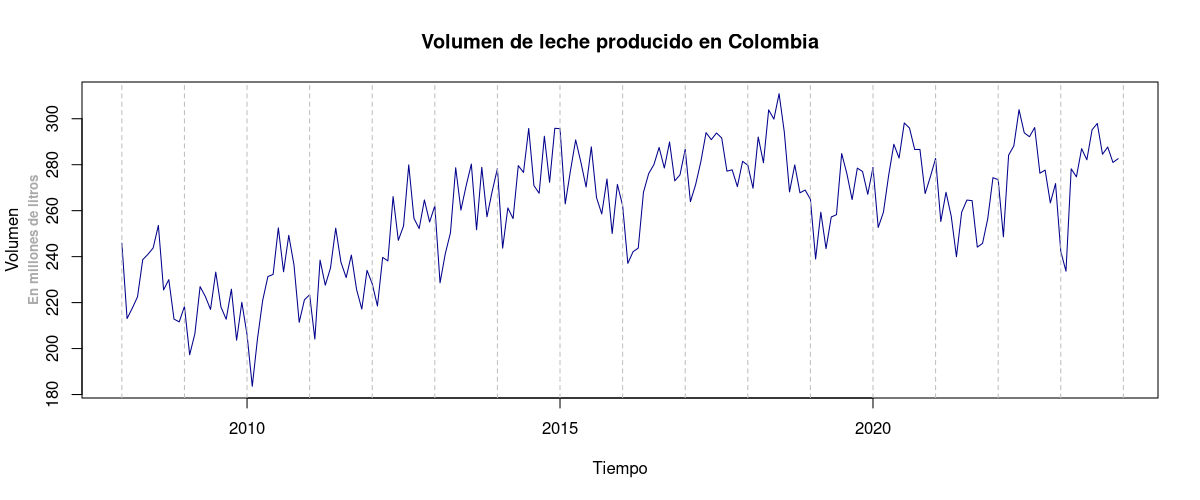

In [21]:
%%R -o leche -w 12 -h 5 --units in -r 100
Ruta = '/home/mendivenson/Documents/GitHub/Time_series/' # Cambie esta ruta a la que corresponda
source(paste0(Ruta,'Script análisis/Leche: Lectura de datos.R'))
abline(v = 2008:2024, col = 'gray', lty = 'dashed')

# **Precio del oro en Colombia (Frecuencia diaria) 🥇**

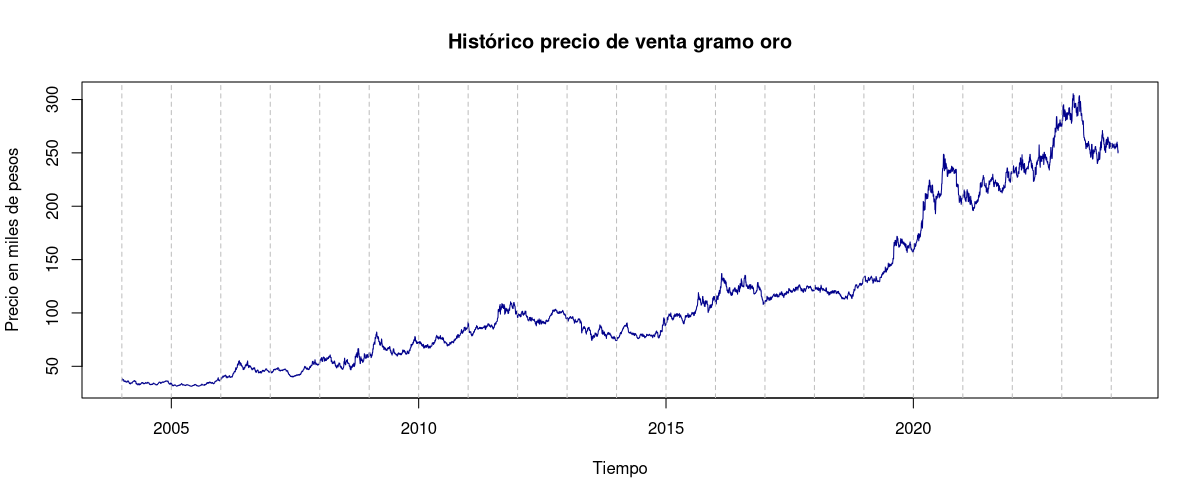

In [22]:
%%R -o leche -w 12 -h 5 --units in -r 100
source(paste0(Ruta,'Script análisis/Oro: Lectura de datos.R'))
abline(v = 2004:2024, col = 'gray', lty = 'dashed')

---

# **Análisis descriptivo**

En el avance 1, se realizaron los respectivos análisis de homocedasticidad, tendencia y estacionalidad para cada una de las series obteniendo los siguientes resultados:

## **Volumen de acopio nacional de leche (Frecuencia mensual)** 🐮

### Estabilización de la varianza

Al buscar un $\lambda$ para la transformación Box Cox encontramos que el que maximiza la log verosimilitud es $3.15$  apróximadamente por lo que se aplica la transformación obteniendo lo siguiente:

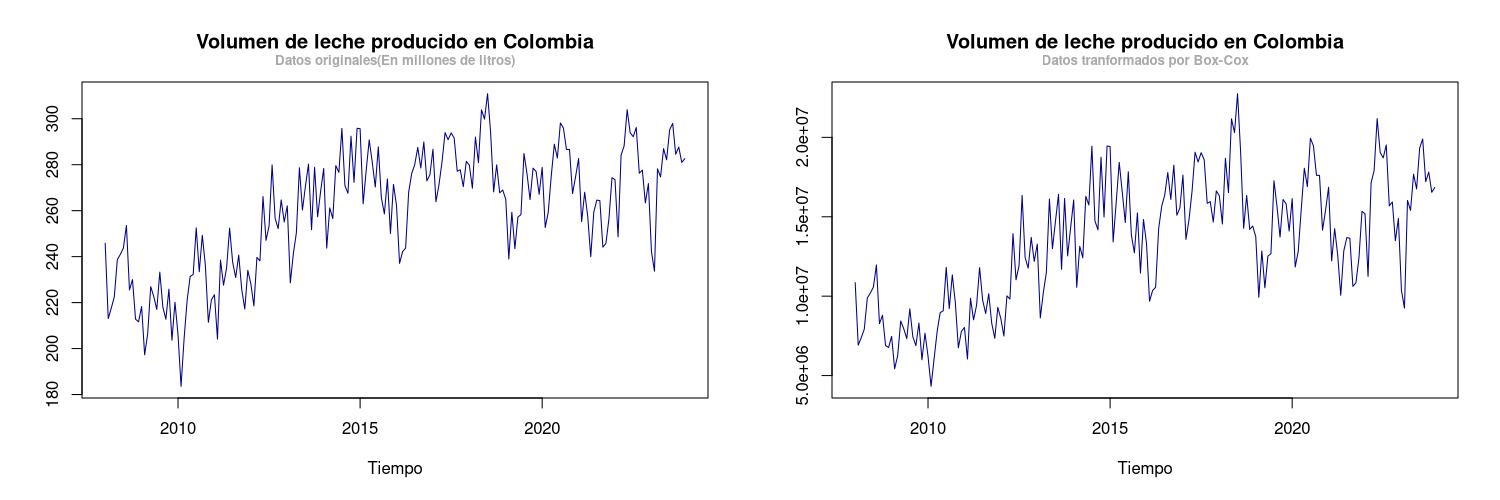

In [23]:
%%R -w 15 -h 5 --units in -r 100
source(paste0(Ruta,'Script análisis/Leche: Análisis de varianza.R'))

Como la serie no cambia realmente de estructura sino que aumenta de forma drástica su escala, se decide no aplicar la transformación Box Cox.

### Eliminación de tendencia

La serie claramente presenta cierta tendencia que al no ser completamente lineal se decide aplicar suavizamiento kernel:

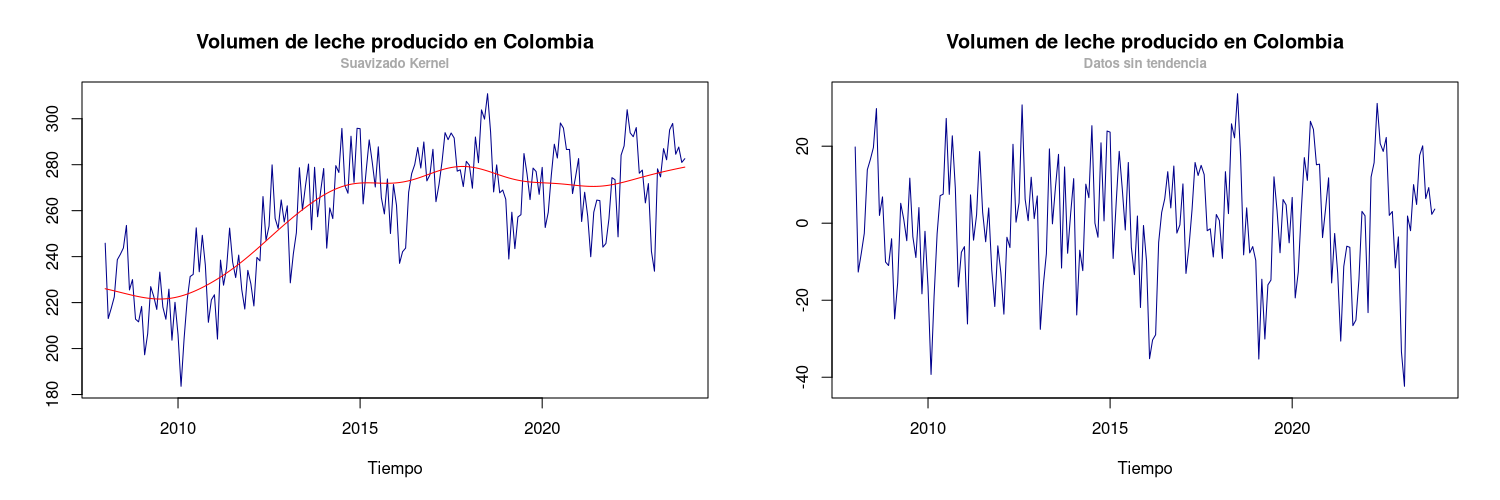

In [24]:
%%R -o leche -w 15 -h 5 --units in -r 100
# -o leche pasa el objeto leche a python como un array: Este objeto se utilizará en los árboles de decisión
# pues estos on útiles para datos sin tendencia
source(paste0(Ruta,'Script análisis/Leche: Eliminación de la tendencia.R'))

### Análisis de estacionalidad

En este caso, se utiizaron distintas herramientas gráficas para determinar la estacionalidad de la serie. Sin embargo, aquí presentamos únicamente el periodograma, las subseries y el gráfico de retardos:

#### Gráfico de retardos

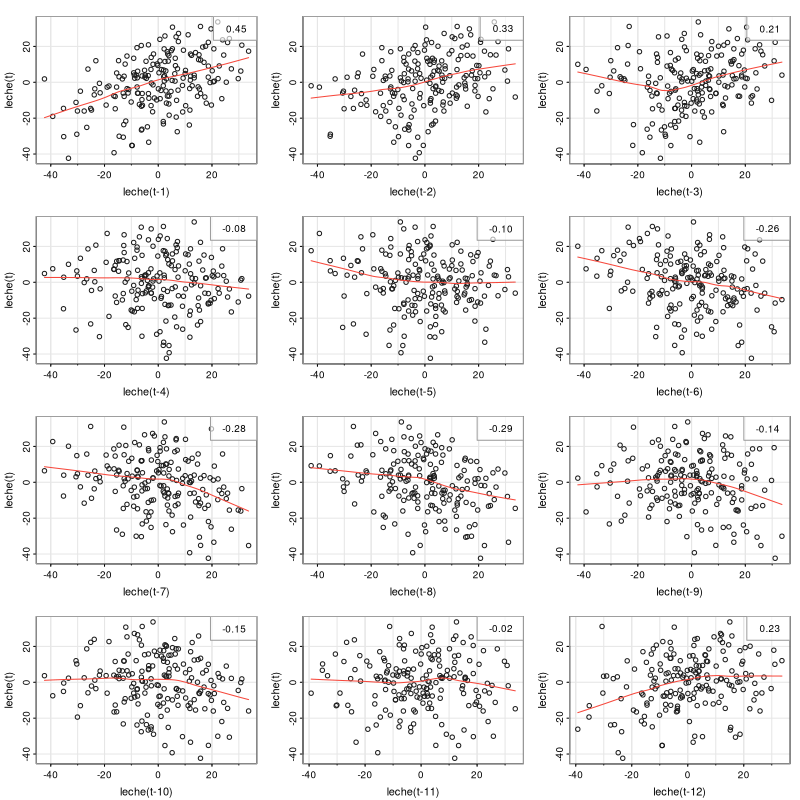

In [25]:
%%R -w 8 -h 8 --units in -r 100
astsa::lag1.plot(leche,12,corr = T)

#### Subseries mensuales

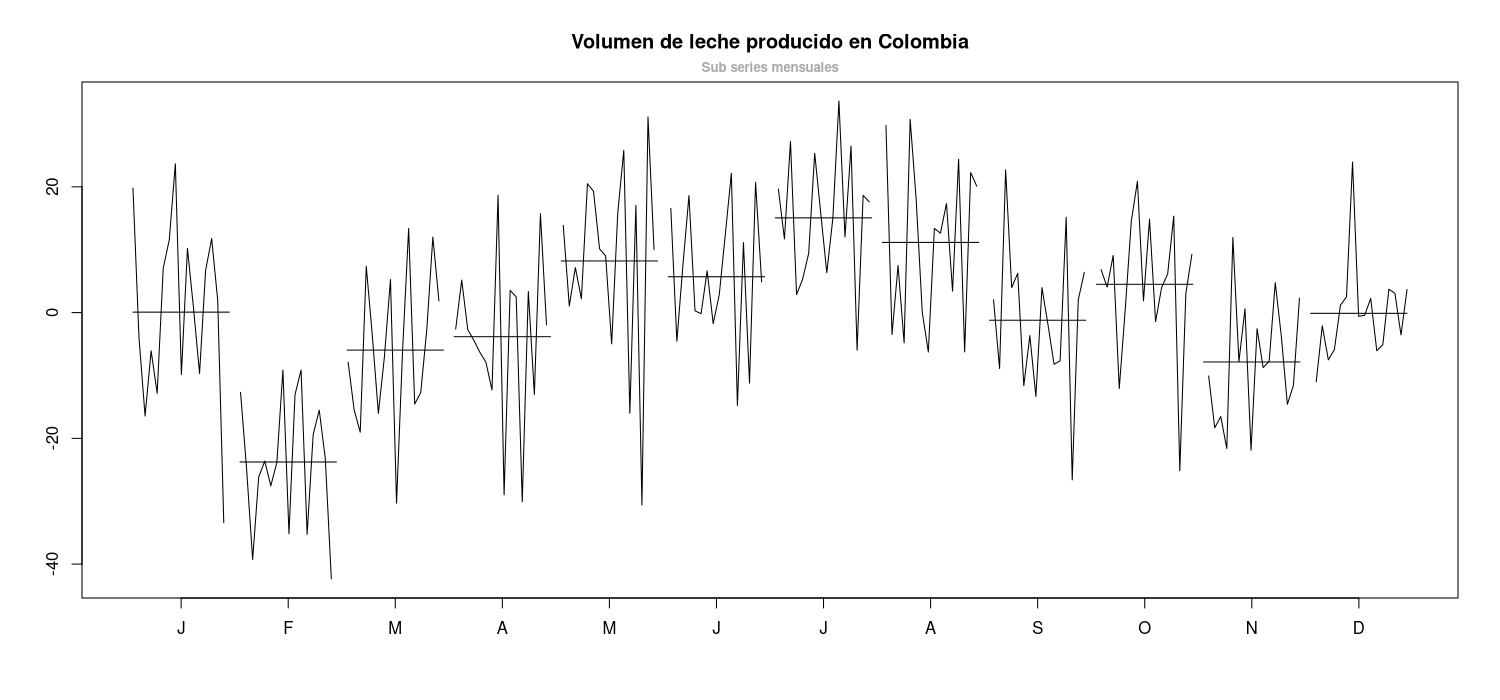

In [26]:
%%R -w 15 -h 7 --units in -r 100
monthplot(leche, ylab = '', main = 'Volumen de leche producido en Colombia')
mtext(bquote(bold('Sub series mensuales')),
      side = 3, line = 0.3, adj = 0.5, cex = 0.8, col = 'darkgray')

#### Periodograma

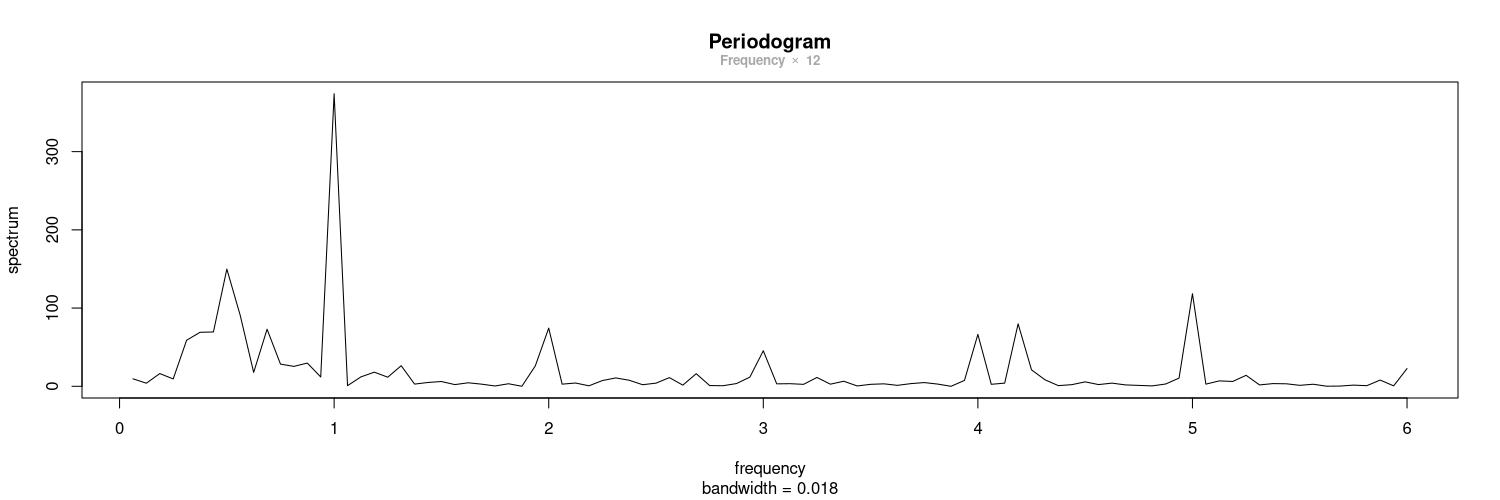

In [27]:
%%R -w 15 -h 5 --units in -r 100
library(latex2exp)
SpectrumLeche = spectrum(leche, log = 'no', main = 'Periodogram')
mtext(TeX('Frequency $\\times$ 12', bold = T),
      side = 3, line = 0.5, adj = 0.5, cex = 0.8, col = 'darkgray')

Luego de probar distintos métodos, se decide utilizar variables dummys para intentar ajustar la estacionalidad de la serie. Los resultados se encuentran a continuación:

El valor máximo no. 1  en el que se máximiza el periodograma es 374.0577 
en la frecuencia  1 
El valor máximo no. 2  en el que se máximiza el periodograma es 149.8748 
en la frecuencia  0.5 
El valor máximo no. 3  en el que se máximiza el periodograma es 118.3689 
en la frecuencia  5 


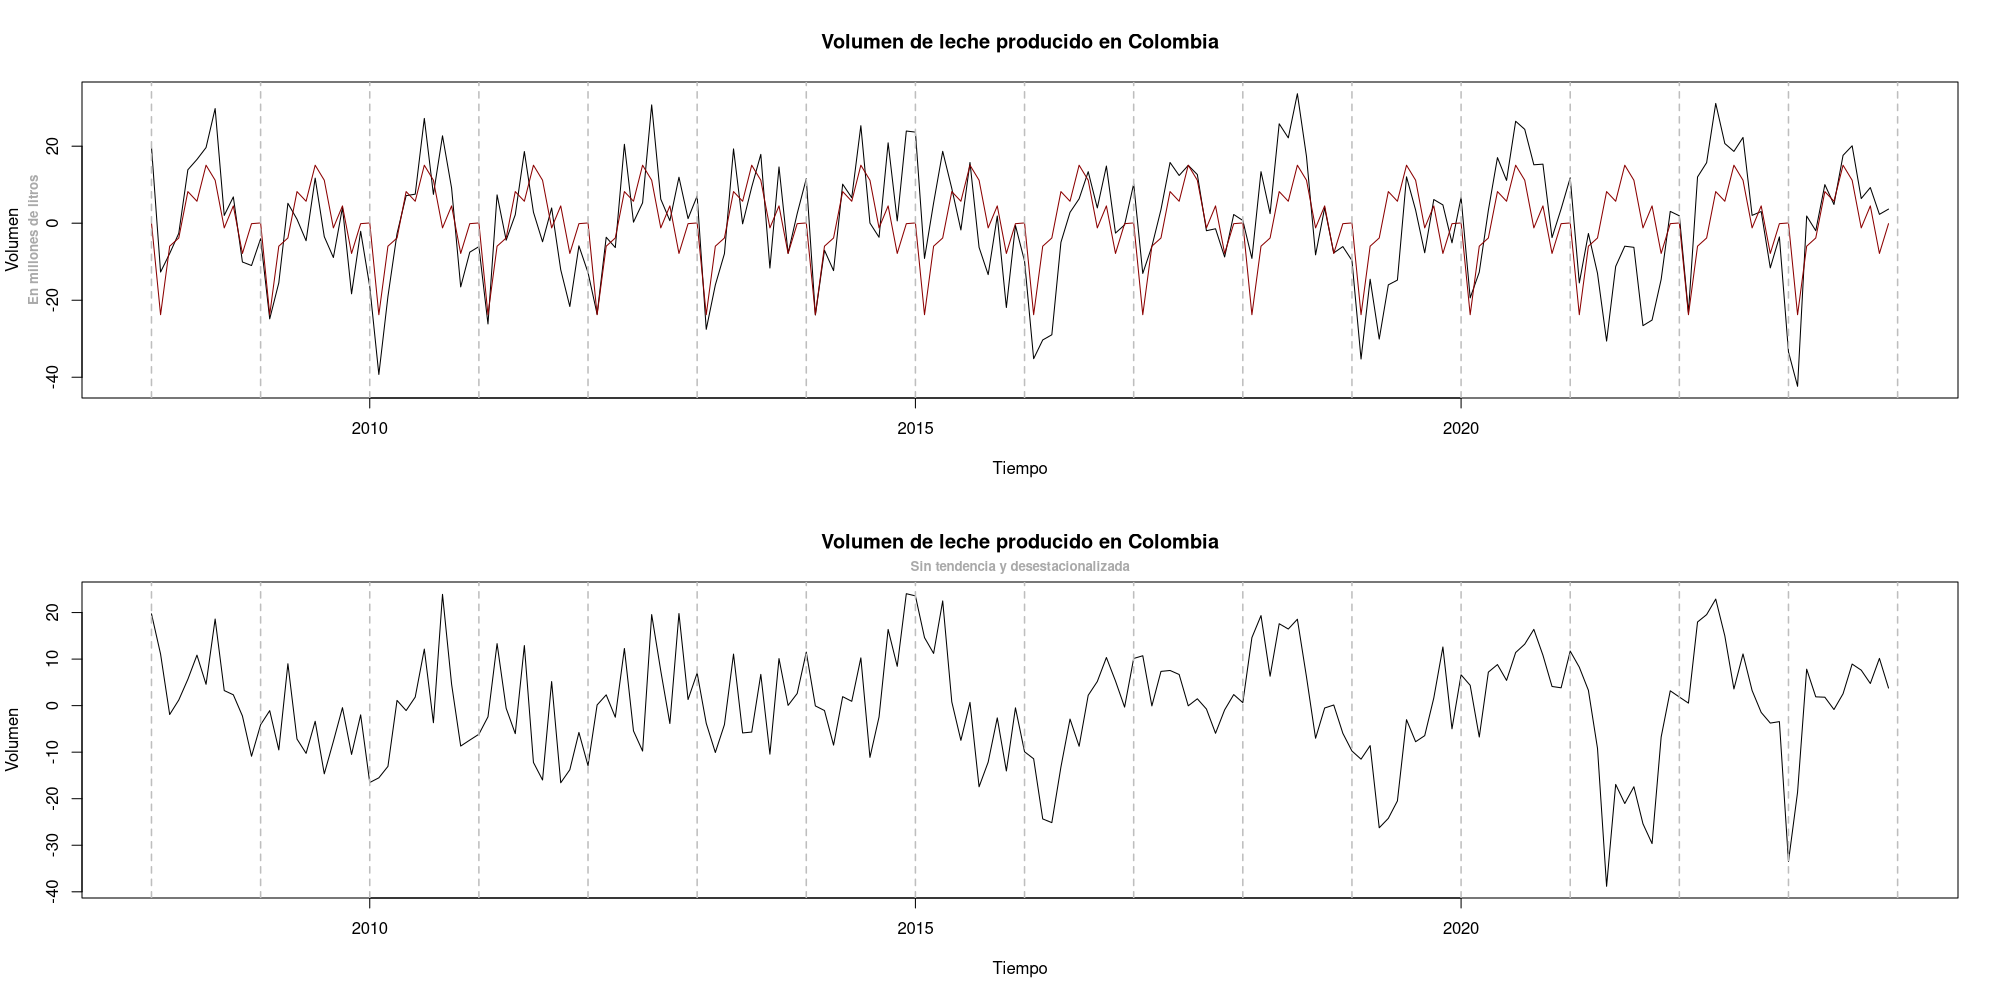

In [28]:
%%R -w 20 -h 10 --units in -r 100
source(paste0(Ruta, 'Script análisis/Leche: Estacionalidad.R'))

## **Precio del oro en Colombia (Frecuencia diaria) 🥇**

### Estabilización de la varianza

Al buscar el $\lambda$ para la transformación Box Cox, encontramos que para el caso de esta serie es muy cercano a cero por lo que aplicamos la transformación de logaritmo natural obteniendo lo siguiente:

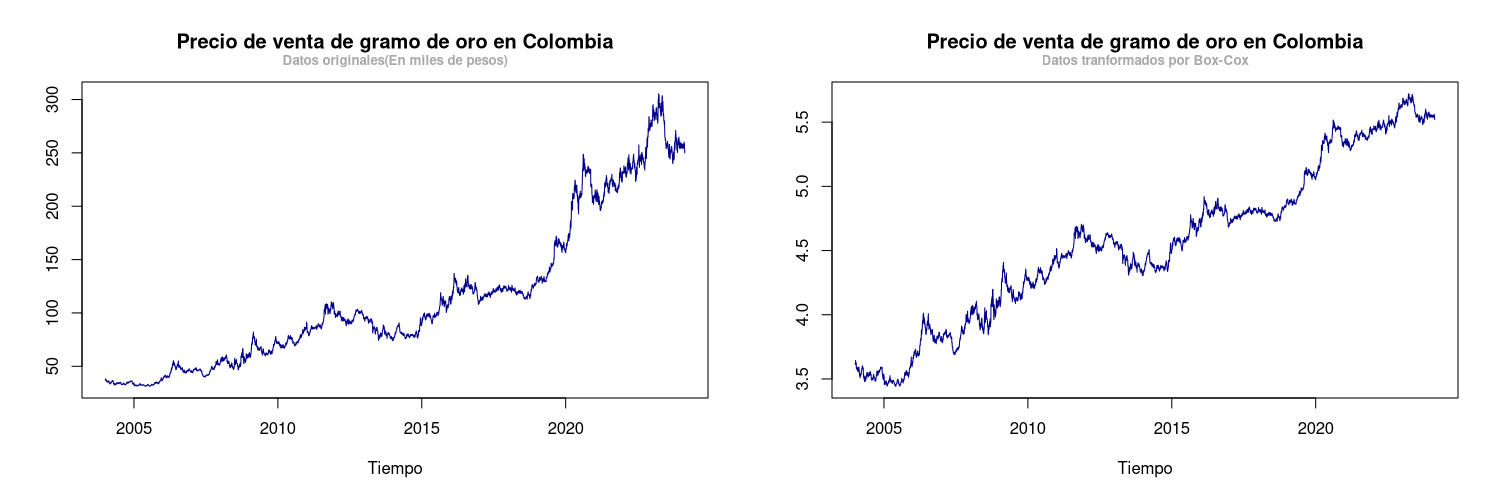

In [29]:
%%R -w 15 -h 5 --units in -r 100
source(paste0(Ruta, 'Script análisis/Oro: Análisis de varianza.R'))

Por lo que se decide usar la serie transformada en cambio de la original debido a que parece que de cierta forma si estabiliza la variabilidad de la serie especialmente para los últimos años

### Eliminación de tendencia

### Análisis de estacionalidad

---

# **Árboles de decisión**

Para los árboles de decisión, tendremos en cuenta lo encontrado en la sección de estacionalidad para escoger nuestros rezagos y además utilizaremos las series sin tendencia:

## **Volumen de acopio nacional de leche (Frecuencia mensual)** 🐮

Como en esta serie, tenemos solamente 192 datos es necesario utilizar validación cruzada para ajustar los hiperparámetros. Además de esto, se escoge el último año (2023) de la serie para servir como datos de prueba o test. Sin embargo, antes de iniciar se debe cambiar el objeto leche de tipo `array` dentro de python a tipo `pandas.ts`:

In [31]:
type(leche)

numpy.ndarray

In [32]:
date_index = pd.date_range(start = '2008-01', periods = len(leche), freq = 'M')
leche = pd.Series(leche, index = date_index)
leche

2008-01-31    19.795864
2008-02-29   -12.682066
2008-03-31    -7.872412
2008-04-30    -2.623688
2008-05-31    13.881874
                ...    
2023-08-31    20.100389
2023-09-30     6.408911
2023-10-31     9.259564
2023-11-30     2.303314
2023-12-31     3.667490
Freq: M, Length: 192, dtype: float64

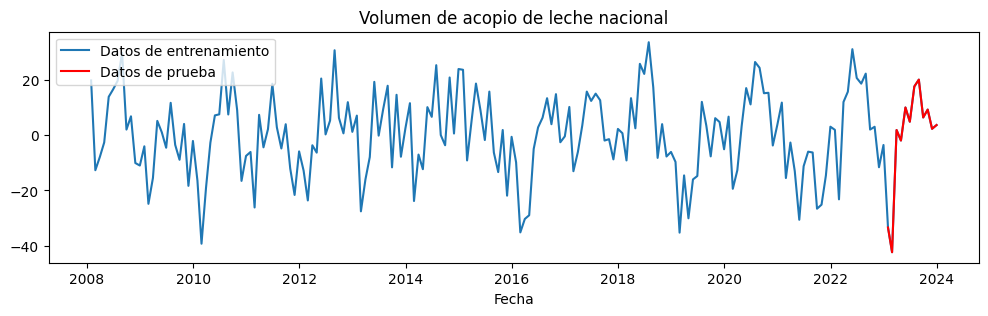

In [33]:
leche_train = leche[0:-12]
leche_test = leche[-12:len(leche)]
plot.figure(figsize = (12,3))

# Datos de entrenamiento
plot.plot(leche.index, leche, label = 'Datos de entrenamiento')

# Datos de prueba
plot.plot(leche_test.index, leche_test, color='red', label='Datos de prueba')

# Leyenda
plot.title('Volumen de acopio de leche nacional')
plot.xlabel('Fecha')
plot.legend(loc = 'upper left')

#### Selección de rezagos y entrenamiento del árbol

En cuanto al entrenamiento del árbol en sí, usaremos la función `ForeCasterAutoreg` del paquete `skforecast.ForecasterAutoreg`:

En cuanto a los rezagos que se utilizarán, tenemos que tener en cuenta que a medida que más lejanos estén lso rezagos más datos perderemos y debido a la cantidad limitada de datos es preferible no escoger rezagos tan lejanos. Además de esto, como la idea es generar árboles para distintos rezagos se escogieron los siguientes:

- Del 1 al 12 de forma secuencial.
- 1, 6 y 12 meses.
- 1, 3, 6,9 y 12 meses.
- 1 y 12 meses.
- 6 y 12 meses.
- 4, 8 y 12 meses.

Además de esto, también necesitamos definir la profundidad máxima del árbol. En este caso, escogemos 10 como máxima profundidad del árbol.

In [35]:
rezagos = [1,2,3,4,5,6,7,8,9,10,11,12,
          [1,6,12],
          [1,3,6,9,12],
          [1,12],
          [6,12],
          [4,8,12]]
hiperparametros = {'max_depth': list(range(1,15)), 
                  'min_samples_leaf': list(range(6,15))}

Una vez definidos estos, creamos un árbol inicial:

In [36]:
tree_leche = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(random_state = 1305),
    lags = 6 # Este valor posiblemente cambiará con la busquéda de hiperparámetros
)

Y ajustamos el árbol usando la búsqueda de grilla. Además, también revisaremos si existe alguna diferencia entre el número de pasos hacia delante para los que se entrenó el modelo y la precisión respecto al conjunto de prueba:

In [37]:
tuning_leche = pd.DataFrame()
for step in range(1,13):
    print(f'{12 * "="}\tEntrenando al modelo {step} pasos adelante\t{12 * "="}')
    tuning = grid_search_forecaster(
    forecaster = tree_leche,
    y = leche_train,
    param_grid = hiperparametros,
    lags_grid = rezagos,
    steps = step,
    refit = True,
    metric = 'mean_squared_error',
    initial_train_size = int(len(leche_train) * 0.8),
    fixed_train_size = False,
    return_best = True,
    verbose = False)

    tuning['Steps'] = step
    tuning['MSE test'] = mean_squared_error(y_true = leche_test,
                                            y_pred = tree_leche.predict(12))
    tuning = tuning[0:1]
    tuning_leche = pd.concat([tuning_leche, tuning], axis = 0)

============	Entrenando al modelo 1 pasos adelante	============
Number of models compared: 2142.


lags grid:   0%|          | 0/17 [00:00<?, ?it/s]

params grid:   0%|          | 0/126 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'max_depth': 10, 'min_samples_leaf': 8}
  Backtesting metric: 125.9081336572329

============	Entrenando al modelo 2 pasos adelante	============
Number of models compared: 2142.


lags grid:   0%|          | 0/17 [00:00<?, ?it/s]

params grid:   0%|          | 0/126 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'max_depth': 8, 'min_samples_leaf': 8}
  Backtesting metric: 137.456790218802

============	Entrenando al modelo 3 pasos adelante	============
Number of models compared: 2142.


lags grid:   0%|          | 0/17 [00:00<?, ?it/s]

params grid:   0%|          | 0/126 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'max_depth': 6, 'min_samples_leaf': 8}
  Backtesting metric: 145.46871241216525

============	Entrenando al modelo 4 pasos adelante	============
Number of models compared: 2142.


lags grid:   0%|          | 0/17 [00:00<?, ?it/s]

params grid:   0%|          | 0/126 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'max_depth': 6, 'min_samples_leaf': 7}
  Backtesting metric: 125.03426045185913

============	Entrenando al modelo 5 pasos adelante	============
Number of models compared: 2142.


lags grid:   0%|          | 0/17 [00:00<?, ?it/s]

params grid:   0%|          | 0/126 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'max_depth': 11, 'min_samples_leaf': 12}
  Backtesting metric: 140.55291907051054

============	Entrenando al modelo 6 pasos adelante	============
Number of models compared: 2142.


lags grid:   0%|          | 0/17 [00:00<?, ?it/s]

params grid:   0%|          | 0/126 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'max_depth': 6, 'min_samples_leaf': 7}
  Backtesting metric: 147.31250982803087

============	Entrenando al modelo 7 pasos adelante	============
Number of models compared: 2142.


lags grid:   0%|          | 0/17 [00:00<?, ?it/s]

params grid:   0%|          | 0/126 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'max_depth': 6, 'min_samples_leaf': 9}
  Backtesting metric: 142.75154901436971

============	Entrenando al modelo 8 pasos adelante	============
Number of models compared: 2142.


lags grid:   0%|          | 0/17 [00:00<?, ?it/s]

params grid:   0%|          | 0/126 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'max_depth': 4, 'min_samples_leaf': 12}
  Backtesting metric: 179.02847019128455

============	Entrenando al modelo 9 pasos adelante	============
Number of models compared: 2142.


lags grid:   0%|          | 0/17 [00:00<?, ?it/s]

params grid:   0%|          | 0/126 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'max_depth': 14, 'min_samples_leaf': 12}
  Backtesting metric: 169.62691203073695

============	Entrenando al modelo 10 pasos adelante	============
Number of models compared: 2142.


lags grid:   0%|          | 0/17 [00:00<?, ?it/s]

params grid:   0%|          | 0/126 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'max_depth': 4, 'min_samples_leaf': 12}
  Backtesting metric: 203.9035568497967

============	Entrenando al modelo 11 pasos adelante	============
Number of models compared: 2142.


lags grid:   0%|          | 0/17 [00:00<?, ?it/s]

params grid:   0%|          | 0/126 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'max_depth': 6, 'min_samples_leaf': 7}
  Backtesting metric: 150.6289373132537

============	Entrenando al modelo 12 pasos adelante	============
Number of models compared: 2142.


lags grid:   0%|          | 0/17 [00:00<?, ?it/s]

params grid:   0%|          | 0/126 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7 8] 
  Parameters: {'max_depth': 8, 'min_samples_leaf': 10}
  Backtesting metric: 155.4785344297701



El modelo que mejor se desempeño en el conjunto de entrenamiento fue:

In [38]:
tuning_leche.sort_values(by = 'mean_squared_error')

,lags,params,mean_squared_error,max_depth,min_samples_leaf,Steps,MSE test
424,"[1, 2, 3, 4]","{'max_depth': 6, 'min_samples_leaf': 7}",125.034260,6,7,4,91.643669
461,"[1, 2, 3, 4]","{'max_depth': 10, 'min_samples_leaf': 8}",125.908134,10,8,1,130.371382
443,"[1, 2, 3, 4]","{'max_depth': 8, 'min_samples_leaf': 8}",137.456790,8,8,2,130.371382
600,"[1, 2, 3, 4, 5]","{'max_depth': 11, 'min_samples_leaf': 12}",140.552919,11,12,5,324.858847
426,"[1, 2, 3, 4]","{'max_depth': 6, 'min_samples_leaf': 9}",142.751549,6,9,7,331.539654
425,"[1, 2, 3, 4]","{'max_depth': 6, 'min_samples_leaf': 8}",145.468712,6,8,3,125.298602
550,"[1, 2, 3, 4, 5]","{'max_depth': 6, 'min_samples_leaf': 7}",147.312510,6,7,6,375.375850
550,"[1, 2, 3, 4, 5]","{'max_depth': 6, 'min_samples_leaf': 7}",150.628937,6,7,11,375.375850
949,"[1, 2, 3, 4, 5, 6, 7, 8]","{'max_depth': 8, 'min_samples_leaf': 10}",155.478534,8,10,12,158.649368
879,"[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 14, 'min_samples_leaf': 12}",169.626912,14,12,9,356.846743


El modelo que mejor se desempeño en el conjunto de prueba fue:

In [39]:
tuning_leche.sort_values(by = 'MSE test')
## Debería preguntar por qué le va mejor al modelo de cuatro pasos hacia delante aún cuando la predicción se hace de forma iterativa .-.

,lags,params,mean_squared_error,max_depth,min_samples_leaf,Steps,MSE test
424,"[1, 2, 3, 4]","{'max_depth': 6, 'min_samples_leaf': 7}",125.034260,6,7,4,91.643669
425,"[1, 2, 3, 4]","{'max_depth': 6, 'min_samples_leaf': 8}",145.468712,6,8,3,125.298602
461,"[1, 2, 3, 4]","{'max_depth': 10, 'min_samples_leaf': 8}",125.908134,10,8,1,130.371382
443,"[1, 2, 3, 4]","{'max_depth': 8, 'min_samples_leaf': 8}",137.456790,8,8,2,130.371382
949,"[1, 2, 3, 4, 5, 6, 7, 8]","{'max_depth': 8, 'min_samples_leaf': 10}",155.478534,8,10,12,158.649368
663,"[1, 2, 3, 4, 5, 6]","{'max_depth': 4, 'min_samples_leaf': 12}",203.903557,4,12,10,277.548561
411,"[1, 2, 3, 4]","{'max_depth': 4, 'min_samples_leaf': 12}",179.028470,4,12,8,282.864272
600,"[1, 2, 3, 4, 5]","{'max_depth': 11, 'min_samples_leaf': 12}",140.552919,11,12,5,324.858847
426,"[1, 2, 3, 4]","{'max_depth': 6, 'min_samples_leaf': 9}",142.751549,6,9,7,331.539654
879,"[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 14, 'min_samples_leaf': 12}",169.626912,14,12,9,356.846743


### Modelo final

Como el argumento `refit` tiene valor verdadero dentro de la función de búsqueda por grilla, en este momento el árbol esta ajustado con la última mejor configuración. Es decir, con profundidad 8 y 12 pasos hacia delante:

In [40]:
tree_leche

ForecasterAutoreg 
Regressor: DecisionTreeRegressor(max_depth=8, min_samples_leaf=10, random_state=1305) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2008-01-31 00:00:00'), Timestamp('2022-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: M 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 8, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 1305, 'splitter': 'best'} 
fit_kwargs: {} 
Creation date: 2024-06-23 16:33:23 
Last fit date: 2024-06-23 16:58:33 
Skforecast version: 0.11.0 
Python version: 3.12.3 
Forecaster id: None 

Es necesario reajustar el modelo para obtener el modelo final:

In [41]:
tree_leche = ForecasterAutoreg(
    regressor = DecisionTreeRegressor(random_state = 1305, max_depth=6, min_samples_leaf=7),
    lags = 4
)

tree_leche.fit(leche_train)

Revisamos que se estén generando las mismas predicciones:

In [42]:
predicciones = tree_leche.predict(12)

In [43]:
MSE = mean_squared_error(y_true = leche_test, y_pred =predicciones)

print(f'MSE test: {MSE}')

MSE test: 91.6436693301634


#### Predicciones puntuales

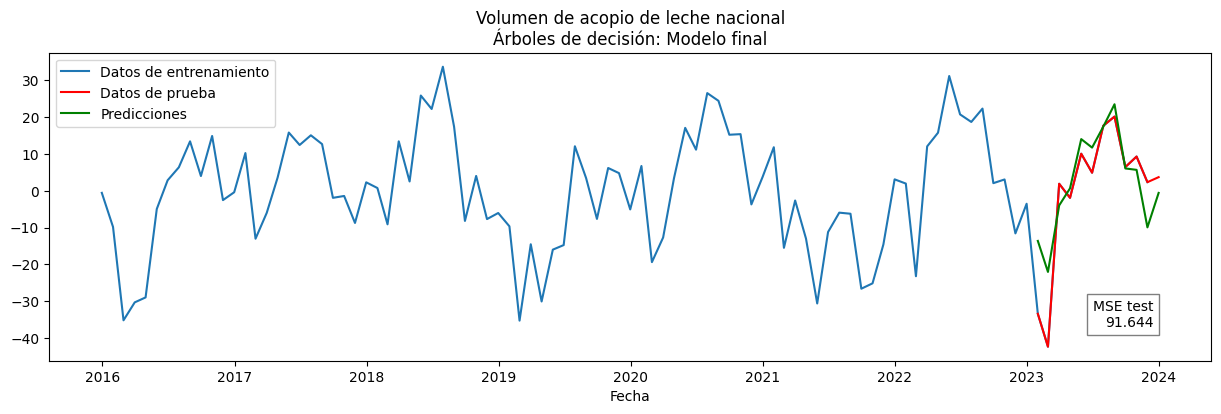

In [44]:
plot.figure(figsize=(15,4))

# Datos de entrenamiento
plot.plot(leche.index[-97:-1], leche[-97:-1], label = 'Datos de entrenamiento')

# Datos de prueba
plot.plot(leche_test.index, leche_test, color='red', label='Datos de prueba')

# Predicciones
plot.plot(leche_test.index, predicciones, color = 'green', label = 'Predicciones')

# Leyenda
plot.title('Volumen de acopio de leche nacional\nÁrboles de decisión: Modelo final')
plot.xlabel('Fecha')
plot.legend(loc = 'upper left')

# Valor de MSE
plot.text(0.95,0.1, f'MSE test\n{MSE:.3f}', horizontalalignment='right', verticalalignment='bottom', 
          transform=plot.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

plot.show()

#### Estructura del árbol

El rezago más importante para la predicción en este caso es el primer rezago:

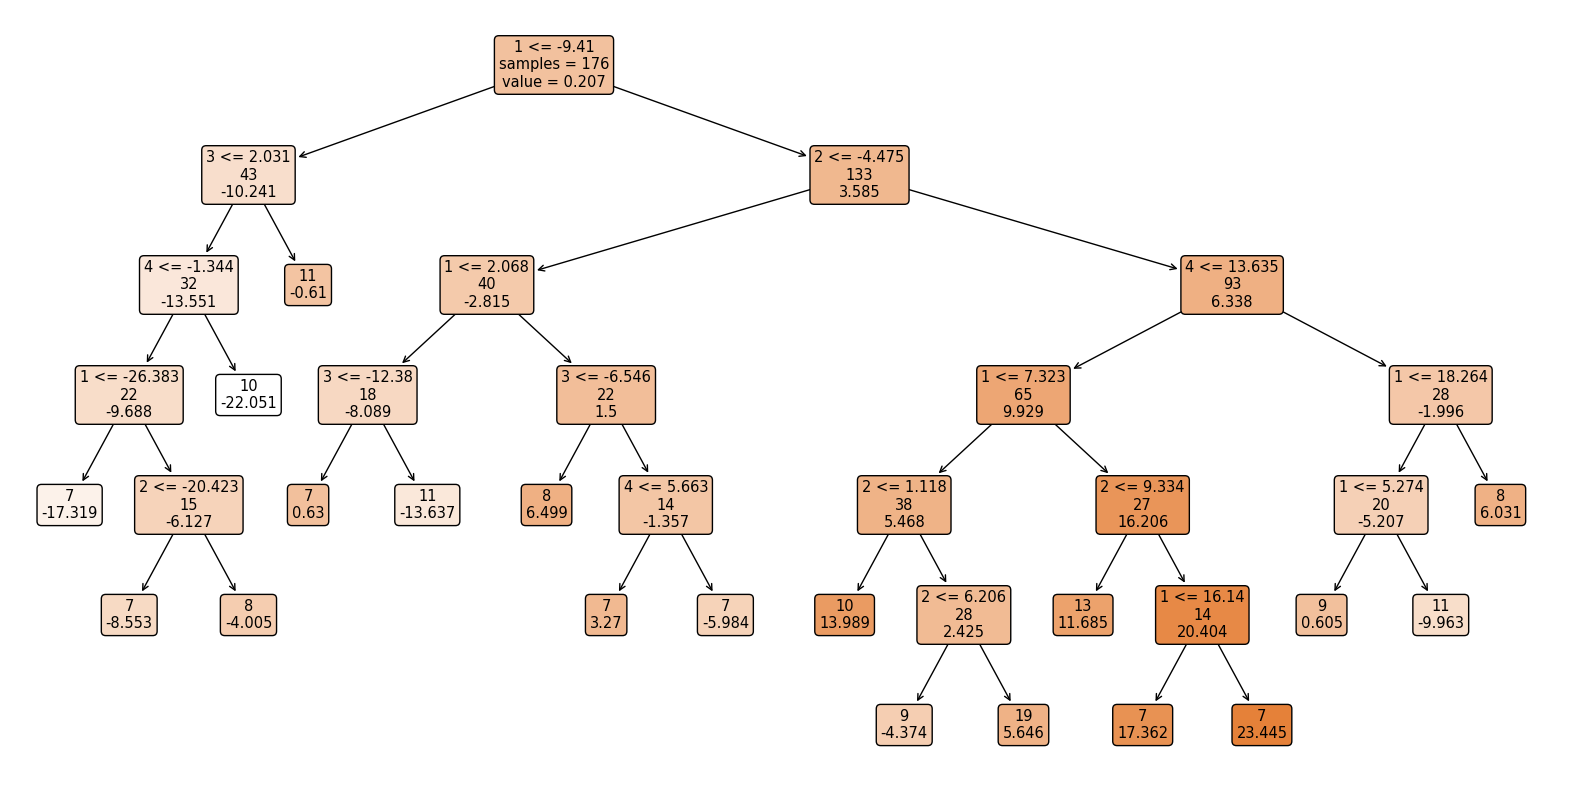

In [45]:
from sklearn.tree import plot_tree

# Crear una visualización del árbol
plot.figure(figsize=(20,10))
plot_tree(tree_leche.regressor, #max_depth = 5,
          filled=True, feature_names=tree_leche.lags, rounded = True,
          impurity = False, label = 'root')
plot.show()

#### Predicciones de intervalo

In [46]:
intervalos = tree_leche.predict_interval(steps = 12,
                           interval = [0.025, 99.75],
                           n_boot = 1000)
intervalos

,pred,lower_bound,upper_bound
2023-01-31,-13.636635,-40.427579,18.558621
2023-02-28,-22.050587,-48.841531,40.201768
2023-03-31,-4.004869,-44.109447,39.694019
2023-04-30,0.629734,-40.501803,41.878890
2023-05-31,13.988646,-39.363147,40.449938
2023-06-30,11.685102,-40.182509,41.878890
2023-07-31,17.362347,-42.973227,40.356624
2023-08-31,23.445418,-41.887480,42.867551
2023-09-30,6.030851,-41.469589,43.616283
2023-10-31,5.645758,-41.167272,43.748980


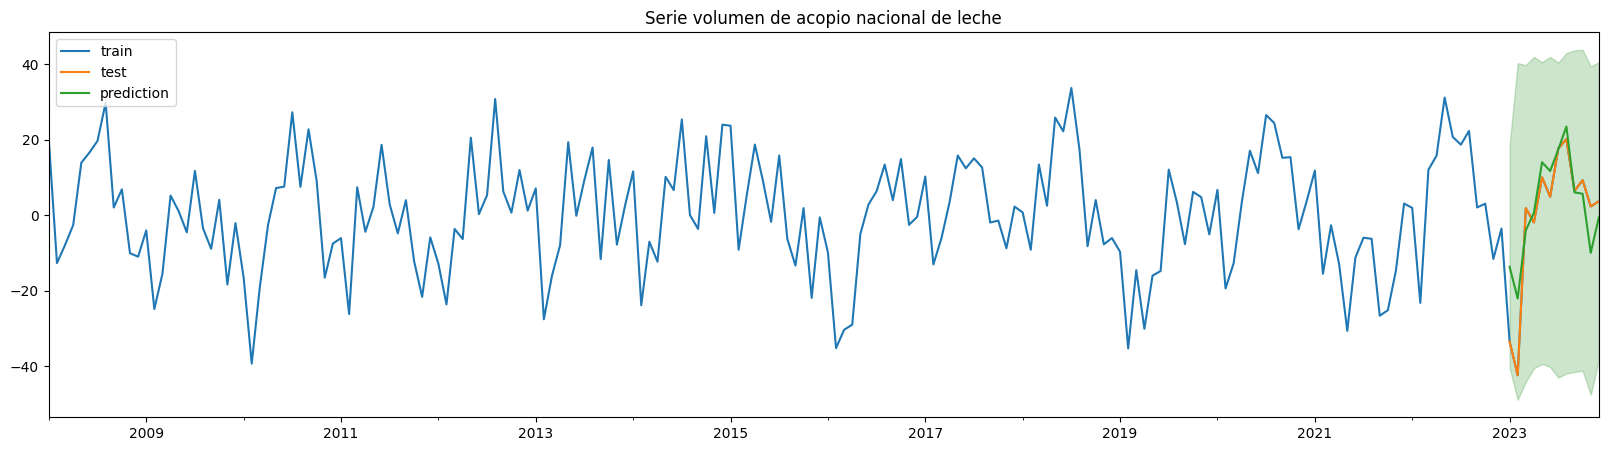

In [53]:
fig, ax = plot.subplots(figsize=(20,5))
leche.plot(ax=ax, label = 'train')
leche_test.plot(ax=ax, label = 'test')
predicciones.plot(ax=ax, label = 'prediction')
ax.fill_between(
    intervalos.index,
    intervalos['lower_bound'],
    intervalos['upper_bound'],
    color = 'green',
    alpha = 0.2
)
plot.title('Serie volumen de acopio nacional de leche')
ax.legend(loc = 'upper left')

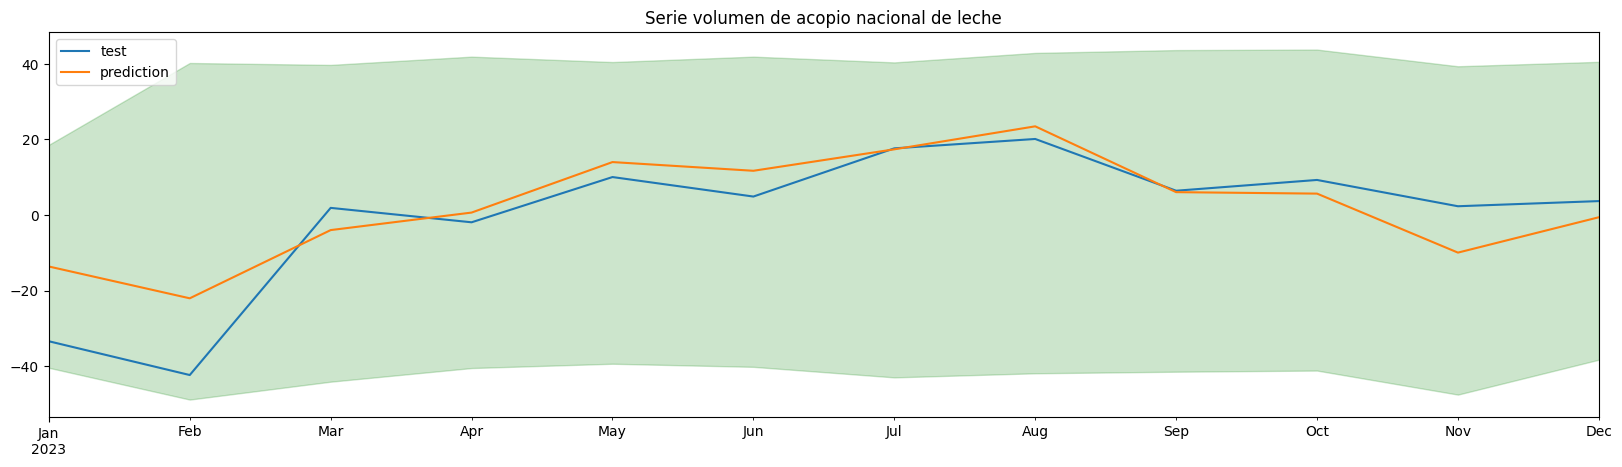

In [55]:
fig, ax = plot.subplots(figsize=(20,5))
leche_test.plot(ax=ax, label = 'test')
predicciones.plot(ax=ax, label = 'prediction')
ax.fill_between(
    intervalos.index,
    intervalos['lower_bound'],
    intervalos['upper_bound'],
    color = 'green',
    alpha = 0.2
)
plot.title('Serie volumen de acopio nacional de leche')
ax.legend(loc = 'upper left')

> **¿Es usual que los intervalos den así de amplios? ¿Tendrá que ver con no haber estabilizado la varianza al inicio?**

## **Precio del oro en Colombia (Frecuencia diaria) 🥇**